In [2]:
from active_learning.learner.standard import Learner, get_classifier
from active_learning.weak_supervision.SelfTraining import SelfTraining
import argparse
import numpy as np
import copy
import pandas as pd
import math
import random
from sklearn.metrics import accuracy_score, f1_score
from timeit import default_timer as timer
from typing import List, Dict
from active_learning.config import get_active_config
from active_learning.dataStorage import DataStorage
from active_learning.datasets import load_synthetic
from active_learning.logger import init_logger
from active_learning.merge_weak_supervision_label_strategies.MajorityVoteLabelMergeStrategy import (
    MajorityVoteLabelMergeStrategy,
)
from collections import Counter

from active_learning.weak_supervision import SyntheticLabelingFunctions
from active_learning.weak_supervision.BaseWeakSupervision import BaseWeakSupervision

import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")


font_size = 8

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "text.usetex": False,
    "font.family": ["Times New Roman", 'sans-serif'],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": font_size,
    "font.size": font_size,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "xtick.bottom": True,
    "figure.autolayout": True,
}

sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams.update(tex_fonts)  # type: ignore


# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_matplotlib_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


#width = 505.89
width = 1500


df = pd.read_csv("new.csv")
df['AMOUNT_OF_LFS'] = np.ceil(df['AMOUNT_OF_LFS'])
df.iloc[0].to_dict()

{'AL_SAMPLES_WEIGHT': 52.0,
 'AMOUNT_OF_LFS': 9.0,
 'DATASET': 'PLANNING',
 'DATASET_RANDOM_GENERATION_SEED': 644168.0,
 'FRACTION_OF_INITIALLY_LABELLED_SAMPLES': 0.5986584841970366,
 'FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES': 0.1560186404424365,
 'JOB_ID': 0.0,
 'LF_RANDOM_SEED': 999891.0,
 'MERGE_WS_SAMPLES_STRATEGY': 'RandomLabelMergeStrategy',
 'acc_WS': '[0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0, 0.10989010989010989, 0.054945054945054944, 0.06593406593406594]',
 'acc_al_and_al': 0.7032967032967034,
 'acc_al_and_ws_and_al': 0.7362637362637363,
 'acc_initial': 0.7032967032967034,
 'acc_ws': 0.7252747252747253,
 'al_sampling_strategy': 'UncertaintyMaxMargin_no_ws',
 'amount_of_initial_al_samples': 55.0,
 'amount_of_lastly_al_samples': 6.0,
 'class_sep': '?',
 'f1_WS': '[0.0, 0.0, 0.10722610722610723, 0.0, 0.0, 0.0, 0.13662013662013658, 0.0815313718539525, 0.09783764622474299]',
 'f1_al_and_al': 0.6328154604016673,
 'f1_al_and_ws_and_al': 0.6337460008346084,
 'f1_initial': 0.617086

Desirable Output: "exps with al_ws_al > ws_al": 
    lf_classifiers_knn:     80% vs 40% (all)
    amount_of_lf_features:  4.5 vs 7.0
    Offene Frage: macht es Sinn den Vergleich gegen ALL zu machen, oder lieber vergleich gegen "not davor"

In [3]:
from tabulate import tabulate


def comparison_table(df, selection):
    print(len(df))
    filtered_df = df[selection]
    not_filtered_df = df[~selection]
    result = [["Amount" ,len(filtered_df), "", len(not_filtered_df), ""]]
    skip_keys = ["DATASET_RANDOM_GENERATION_SEED", "LF_RANDOM_SEED", "random_state", "JOB_ID", ]
    for key in df.keys():
        if key in skip_keys:
            continue
        if df.dtypes[key] == np.float64 or df.dtypes[key] == np.int64:
            selection = filtered_df[key]
            not_selection = not_filtered_df[key]
            average = selection.mean()
            not_average = not_selection.mean()
            error_area = 1.96 * selection.std() / math.sqrt(selection.count())
            not_error_area = (
                1.96 * not_selection.std() / math.sqrt(not_selection.count())
            )
            result.append((key, "{:4.2}".format(average), "±{:4.2%}".format(error_area), "{:4.2}".format(not_average), "±{:4.2%}".format(not_error_area)))

        elif df.dtypes[key] == object:
            average = " | ".join(
                [
                    k + ": " + str(v)
                    for k, v in filtered_df[key].value_counts().nlargest(5).iteritems()
                ]
            )
            not_average = ",".join(
                [
                    k + ": " + str(v)
                    for k, v in not_filtered_df[key]
                    .value_counts()
                    .nlargest(5)
                    .iteritems()
                ]
            )
            result.append((key, average, "", not_average, ""))
        else:
            print(key)
            print(df.dtypes[key])

    return result

    """
    mean = selection.mean()
    error_area = 1.96 * selection.std() / math.sqrt(
            selection.count()
        )
    results.append([key, mean, error_area])
    print(TITLE)
    print("{:>60} {:>6} {:>4}".format("", "Mean", ""))
    for result in results:
        print("{:<50} {:>6.2%} ±{:>4.2%}".format(result[0], float(result[1]), float(result[2])))
    """


result = comparison_table(
    df, df["acc_al_and_ws_and_al"] > df["acc_ws"] 
)
print("Accuracy after AL, WS, AL is greater than after AL and WS")
tabulate(result, tablefmt='html')

50640
Accuracy after AL, WS, AL is greater than after AL and WS


Amount,25002,,25638,
AL_SAMPLES_WEIGHT,5e+01,±35.33%,5e+01,±35.08%
AMOUNT_OF_LFS,4.7,±3.00%,4.8,±3.04%
DATASET,synthetic: 11674 | cifar10: 1348 | flag: 1101 | australian: 1031 | DIABETES: 954,,"synthetic: 5048,FERTILITY: 1548,HEART: 1545,BREAST: 1237,dwtc: 1219",
FRACTION_OF_INITIALLY_LABELLED_SAMPLES,0.47,±0.34%,0.5,±0.35%
FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES,0.54,±0.34%,0.47,±0.36%
MERGE_WS_SAMPLES_STRATEGY,RandomLabelMergeStrategy: 9433 | MajorityVoteLabelMergeStrategy: 8483 | SnorkelLabelMergeStrategy: 7086,,"MajorityVoteLabelMergeStrategy: 10099,RandomLabelMergeStrategy: 9467,SnorkelLabelMergeStrategy: 6072",
acc_WS,"[0.0, 0.0]: 166 | [0.0, 0.0, 0.0]: 60 | [0.0, 0.0, 0.0, 0.0]: 54 | [0.234375, 0.234375]: 26 | [0.7216494845360825, 0.7525773195876289]: 23",,"[0.0, 0.0]: 398,[0.82, 0.82]: 330,[0.82, 0.82, 0.82]: 240,[0.0, 0.0, 0.0]: 198,[0.82, 0.82, 0.82, 0.82]: 168",
acc_al_and_al,0.65,±0.28%,0.59,±0.34%
acc_al_and_ws_and_al,0.63,±0.27%,0.59,±0.32%
acc_initial,0.63,±0.28%,0.61,±0.33%


In [4]:
result = comparison_table(
    df, (df["n_repeated"] > 4 )&(df["n_redundant"] >8)
)
print("Accuracy after AL, WS, AL is greater than after AL and WS")
tabulate(result, tablefmt='html')

50640
Accuracy after AL, WS, AL is greater than after AL and WS


Amount,7842,,42798,
AL_SAMPLES_WEIGHT,4.9e+01,±63.06%,5e+01,±27.09%
AMOUNT_OF_LFS,4.7,±5.30%,4.8,±2.33%
DATASET,synthetic: 7842,,"synthetic: 8880,HABERMAN: 1860,australian: 1812,dwtc: 1734,ILPD: 1728",
FRACTION_OF_INITIALLY_LABELLED_SAMPLES,0.49,±0.63%,0.48,±0.27%
FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES,0.49,±0.63%,0.51,±0.27%
MERGE_WS_SAMPLES_STRATEGY,RandomLabelMergeStrategy: 2964 | MajorityVoteLabelMergeStrategy: 2850 | SnorkelLabelMergeStrategy: 2028,,"RandomLabelMergeStrategy: 15936,MajorityVoteLabelMergeStrategy: 15732,SnorkelLabelMergeStrategy: 11130",
acc_WS,"[0.0, 0.0]: 30 | [0.0, 0.0, 0.0]: 12 | [0.0, 0.0, 0.0, 0.0, 0.0]: 6 | [0.24843423799582465, 0.4033402922755741, 0.33194154488517746, 0.3883089770354906, 0.43966597077244257, 0.24634655532359082, 0.39707724425887264, 0.3874739039665971, 0.37118997912317325]: 6 | [0.21428571428571427, 0.24285714285714285]: 6",,"[0.0, 0.0]: 534,[0.82, 0.82]: 330,[0.0, 0.0, 0.0]: 246,[0.82, 0.82, 0.82]: 240,[0.0, 0.0, 0.0, 0.0]: 198",
acc_al_and_al,0.68,±0.42%,0.61,±0.25%
acc_al_and_ws_and_al,0.64,±0.43%,0.61,±0.24%
acc_initial,0.65,±0.45%,0.61,±0.24%


<AxesSubplot:>

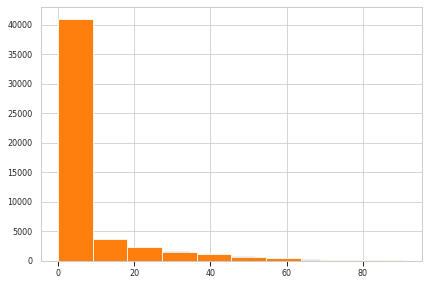

In [5]:
df['n_redundant'].hist()
df['n_repeated'].hist()